In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
from scipy import signal
import os

class MemmapDataset(Dataset):
    def __init__(self, descriptor_path, padding_handling="remove", interp_length=None, transform=None, filter=False):
        """
        Args:
            descriptor_path (str): Path to the descriptor JSON file (e.g., 'descriptor.json').
            padding_handling (str or float): How to handle np.inf padding values.
                - "remove" (default): Remove the padded np.inf values and return variable-length arrays.
                - A float: Replace any np.inf values with the given float.
            interp_length (int, optional): If provided, the ADC data (adc1 and adc2) will be
                first stripped of np.inf padding and then interpolated to this fixed length.
            transform (callable, optional): Optional transform to be applied on a sample.
            filter (bool, optional): Whether to apply a bandpass filter to the audio data.
        """
        # Load descriptor from JSON file.
        with open(descriptor_path, 'r') as f:
            self.descriptor = json.load(f)
        
        # Extract required parameters from the descriptor.
        self.audio_sampling_rate = self.descriptor['audio_sampling_rate']
        self.adc_sampling_rate = self.descriptor['adc_sampling_rate']
        self.audio_lowcut       = self.descriptor['audio_lowcut']
        self.audio_highcut      = self.descriptor['audio_highcut']
        self.adc_lowcut         = self.descriptor['adc_lowcut']
        self.adc_highcut        = self.descriptor['adc_highcut']
        self.max_audio_len      = self.descriptor['max_audio_len']
        self.max_adc_len        = self.descriptor['max_adc_len']
        self.n_segments         = self.descriptor['n_segments']
        self.memmap_filename    = self.descriptor['memmap_filename']
        self.dataset_mapping    = self.descriptor['dataset_mapping']
        # Rebuild the dtype from the descriptor.
        self.dtype = np.dtype([tuple(item) for item in self.descriptor['dtype']])
        
        # Open the memmap file in read-only mode using the number of segments from the descriptor.
        self.memmap = np.memmap(self.memmap_filename, dtype=self.dtype, mode='r', shape=(self.n_segments,))
        
        self.transform = transform
        self.padding_handling = padding_handling
        self.interp_length = interp_length
        self.filter = filter

    def __len__(self):
        return self.n_segments

    def __getitem__(self, index):
        # Retrieve the record from the memmap.
        row = self.memmap[index]
        
        # Convert fixed-size arrays to numpy arrays.
        audio_arr = np.array(row['audio'])
        adc1_arr = np.array(row['adc1'])
        adc2_arr = np.array(row['adc2'])
        
        # Process audio channel using the padding handling method.
        audio_arr = self._handle_padding(audio_arr, self.padding_handling)
        adc1_arr = self._handle_padding(adc1_arr, self.padding_handling)
        adc2_arr = self._handle_padding(adc2_arr, self.padding_handling)
        
        if self.filter:
            audio_arr = self.BPfilter(audio_arr, self.audio_sampling_rate, self.audio_lowcut, self.audio_highcut)
            adc1_arr = self.BPfilter(adc1_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)
            adc2_arr = self.BPfilter(adc2_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)

        # Process ADC channels.
        if self.interp_length is not None:
            audio_arr = self._interpolate_channel(audio_arr, self.interp_length)
            adc1_arr = self._interpolate_channel(adc1_arr, self.interp_length)
            adc2_arr = self._interpolate_channel(adc2_arr, self.interp_length)
        
        # Create a sample tuple.
        # Use .copy() to ensure the arrays have positive strides.
        sample = ( 
            int(row['id']), 
            torch.from_numpy(audio_arr.copy()).float(),  
            torch.from_numpy(adc1_arr.copy()).float(), 
            torch.from_numpy(adc2_arr.copy()).float(),  
        )
        
        if self.transform:
            sample = self.transform(sample)
        return sample

    def _handle_padding(self, arr, mode):
        """
        Handle the np.inf padded values in the array.
        If mode is "remove", return the array with inf values removed.
        If mode is a float, replace inf values with that float.
        """
        if mode == "remove":
            return arr[~np.isinf(arr)]
        elif isinstance(mode, (int, float)):
            return np.where(np.isinf(arr), mode, arr)
        else:
            raise ValueError("Invalid padding_handling value. Use 'remove' or a float value.")

    def _interpolate_channel(self, arr, target_length):
        """
        Remove np.inf values from the array and linearly interpolate
        to the target_length.
        """
        # Remove padded inf values.
        valid = arr[~np.isinf(arr)]
        if len(valid) == 0:
            # If there is no valid data, return an array of zeros.
            return np.zeros(target_length, dtype=arr.dtype)
        # Generate new indices for interpolation.
        old_indices = np.arange(len(valid))
        new_indices = np.linspace(0, len(valid) - 1, target_length)
        return np.interp(new_indices, old_indices, valid)[:target_length]

    def get(self, field):
        """
        Return the value of the given descriptor field.
        For example, dataset.get("audio_sampling_rate") returns the audio sampling rate.
        """
        return self.descriptor.get(field, None)

    def id_to_dataset(self, id):
        """
        Return the dataset string for the given ID.
        """
        return self.dataset_mapping.get(str(id), "Unknown")

    def get_Nclasses(self):
        """
        Return the number of unique datasets in the dataset_mapping.
        """
        return len(set(self.dataset_mapping.values()))
    
    def BPfilter(self, data, fs, lowcut_hz=None, highcut_hz=None):
        """
        Apply a bandpass Butterworth filter to the input data.
        
        Parameters:
        data : array-like
            The input signal to filter
        fs : float
            Sampling frequency in Hz
        lowcut_hz : float, optional
            Lower cutoff frequency in Hz. If None, defaults to 20 Hz
        highcut_hz : float, optional
            Upper cutoff frequency in Hz. If None, defaults to fs/4 Hz
            
        Returns:
        array-like
            The filtered signal
        """
        # Default cutoff frequencies if not provided.
        if lowcut_hz is None:
            lowcut_hz = 20  # Default lower cutoff of 20 Hz
        if highcut_hz is None:
            highcut_hz = fs/4  # Default upper cutoff at quarter of sampling rate
        
        # Convert cutoff frequencies to normalized units (0 to 1).
        nyquist = fs / 2
        low = lowcut_hz / nyquist
        high = highcut_hz / nyquist
        
        # Create a 4th-order bandpass Butterworth filter.
        b, a = signal.butter(2, [low, high], btype='band')
        
        # Apply zero-phase filtering using filtfilt.
        filtered_data = signal.filtfilt(b, a, data)
        return filtered_data

class normalizer():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        id, audio, adc1, adc2 = sample
        audio = (audio - self.mean[0]) / self.std[0]
        adc1 = (adc1 - self.mean[1]) / self.std[1]
        adc2 = (adc2 - self.mean[1]) / self.std[1]
        return id, audio, adc1, adc2

input_length = 512
# Path to the descriptor JSON file.
descriptor_path = 'samdescriptor.json'
# Create a dataset instance that interpolates ADC channels to length 300, with filtering.
dataset = MemmapDataset(descriptor_path, padding_handling="remove", interp_length=input_length, filter=True)
# dataset = MemmapDataset(descriptor_path, padding_handling="remove", filter=True)
transform = normalizer(mean=[dataset.get("audio_mean"), dataset.get("adc_mean")], std=[dataset.get("audio_std"), dataset.get("adc_std")])
dataset.transform = transform
output_length = dataset.get_Nclasses()
print("Number of classes:", output_length)
sample = dataset[1]
print(f"\nWith ADC interpolation to length {input_length}:")
print("ADC1 shape:", sample[2].shape)
print("ADC2 shape:", sample[3].shape)

# Demonstrate accessing a descriptor field.
print("Audio Sampling Rate:", dataset.get("audio_sampling_rate"))
print("ADC Highcut:", dataset.get("adc_highcut"))


Number of classes: 38

With ADC interpolation to length 512:
ADC1 shape: torch.Size([512])
ADC2 shape: torch.Size([512])
Audio Sampling Rate: 48000
ADC Highcut: 3700


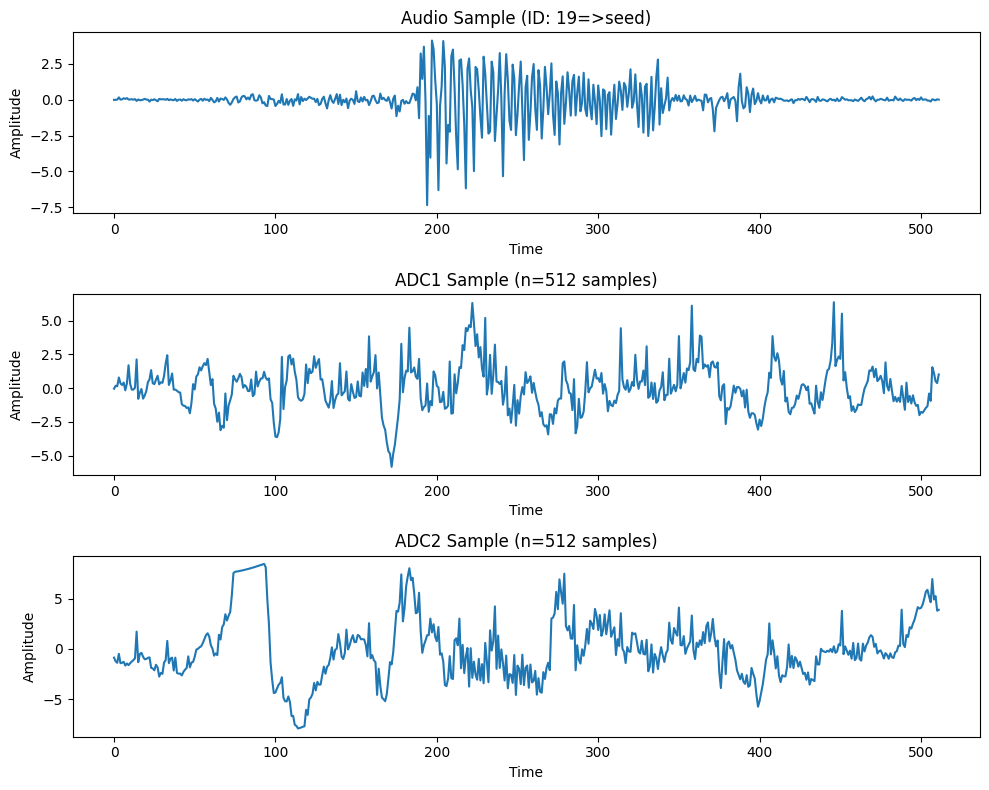

In [2]:
import matplotlib.pyplot as plt


rng_index = np.random.randint(0, len(dataset))
sample = dataset[rng_index]

sample_id, audio, adc1, adc2 = sample  # unpack the tuple

# Convert tensors to numpy arrays for plotting
audio_np = audio.numpy()
adc1_np = adc1.numpy()
adc2_np = adc2.numpy()

# Create a figure with three subplots for audio, ADC1, and ADC2.
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

axs[0].plot(audio_np)
axs[0].set_title(f"Audio Sample (ID: {sample_id}=>{dataset.id_to_dataset(sample_id)})")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Amplitude")

axs[1].plot(adc1_np)
axs[1].set_title(f"ADC1 Sample (n={len(adc1_np)} samples)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Amplitude")

axs[2].plot(adc2_np)
axs[2].set_title(f"ADC2 Sample (n={len(adc2_np)} samples)")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [3]:
# from torchprofile import profile_macs

import torch.nn as nn
import torch.nn.functional as F

# the data shape is (batch_size, 2, input_length)
# where 2 is the number of ADC channels and input_length is the length of each ADC channel.
# the output shape is (batch_size, output_length) where output_length is the number of classes.

# def computeModelStats(model, input_shape):
#     dummy_input = torch.randn(input_shape)
#     macs = profile_macs(model, dummy_input)
#     params = sum(p.numel() for p in model.parameters())
#     model_size = params * 4 / (1024 ** 2)  # Convert to MB assuming 32-bit (4 bytes) precision
#     print(f"MACs: {macs}")
#     print(f"Parameters: {params}")
#     print(f"Model Size: {model_size:.2f} MB")

def computeModelSize(model):
    params = sum(p.numel() for p in model.parameters())
    model_size = params * 4 / (1024 ** 2)  # Convert to MB assuming 32-bit (4 bytes) precision
    return model_size

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ELU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, input_length, input_dim,output_length):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ELU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 128, 4)
        self.layer2 = self._make_layer(128, 256, 2, stride=2)
        self.layer3 = self._make_layer(256, 512, 2, stride=2)
        self.layer4 = self._make_layer(512, 512, 4, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, output_length)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class SmallResNet(nn.Module):
    def __init__(self, input_length, input_dim, output_length):
        super(SmallResNet, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ELU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(32, 64, 4)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 4, stride=2)
        self.layer4 = self._make_layer(256, 256, 4, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, output_length)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Test the model with dummy data
dummy = torch.randn(4, 2, input_length)
model = ResNet(input_length, 2, output_length)
# Smodel = SmallResNet(input_length, 2, output_length)
output = model(dummy)
# Soutput = Smodel(dummy)
print("Output shape is:", output.shape)
print(model)
# print("Small Output shape is:", Soutput.shape)
# print(Smodel)

# Compute model stats
# computeModelStats(model, (1, 2, input_length))
print(f"Model Size: {computeModelSize(model):.2f} MB")
# print(f"Small Model Size: {computeModelSize(Smodel):.2f} MB")

Output shape is: torch.Size([4, 38])
ResNet(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ELU(alpha=1.0, inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(alpha=1.0, inplace=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (

In [4]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_epoch(
    model,
    dataloader,
    epochs,
    learning_rate,
    optimizer=None,
    loss_function=None,
    scheduler=None,
    device='cpu',
    verbose=0,
    log_interval=100,
    logger=None,
):
    if loss_function is None:
        loss_function = nn.CrossEntropyLoss()
    
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    model.train()

    epoch_results = []

    for epoch in tqdm(range(epochs), desc="Training Epochs", disable=(verbose == 0)):
        total_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0
        
        for batch_idx, (ids, audio, adc1, adc2) in enumerate(dataloader):
            audio = audio.to(device)
            adc1 = adc1.to(device)
            adc2 = adc2.to(device)
            ids = ids.to(device)
            
            adc = torch.stack((adc1, adc2), dim=1)
            adc+= torch.randn_like(adc) * 0.04
            outputs = model(adc)
            loss = loss_function(outputs, ids)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == ids).sum().item()
            total += ids.size(0)
            
            # if verbose > 0 and (batch_idx % log_interval == 0):
            #     msg = f"[TRAIN] Epoch: {epoch}/{epochs}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%"
            #     if verbose == 1:
            #         print(msg)
            #     if logger is not None and verbose != 0:
            #         logger.log({"split": "train", "epoch": epoch, "batch_idx": batch_idx, "loss": loss.item(), "accuracy": 100 * correct / total})

        if scheduler is not None:
            scheduler.step()

        avg_loss = total_loss / max(num_batches, 1)
        accuracy = 100 * correct / total
        epoch_results.append((avg_loss, accuracy))
        if verbose == 1:
            print(f"[TRAIN] End of Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        if logger is not None and verbose != 0:
            logger.log({"split": "train", "epoch": epoch, "avg_loss": avg_loss, "accuracy": accuracy})


    return epoch_results


def test_epoch(
    model,
    dataloader,
    epochs=1,
    loss_function=None,
    device='cpu',
    verbose=0,
    log_interval=100,
    logger=None,
):
    if loss_function is None:
        loss_function = nn.CrossEntropyLoss()

    model.to(device)
    model.eval()

    epoch_results = []

    for epoch in tqdm(range(epochs), desc="Testing Epochs", disable=(verbose == 0)):
        total_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0

        with torch.no_grad():
            for batch_idx, (ids, audio, adc1, adc2) in enumerate(dataloader):
                ids = ids.to(device)
                adc1 = adc1.to(device)
                adc2 = adc2.to(device)
                
                adc = torch.stack((adc1, adc2), dim=1)
                outputs = model(adc)
                loss = loss_function(outputs, ids)
                
                total_loss += loss.item()
                num_batches += 1
                
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == ids).sum().item()
                total += ids.size(0)
                
                # if verbose > 0 and (batch_idx % log_interval == 0):
                #     msg = f"[TEST] Epoch: {epoch}/{epochs}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%"
                #     if verbose == 1:
                #         print(msg)
                #     if logger is not None and verbose != 0:
                #         logger.log({"split": "test", "epoch": epoch, "batch_idx": batch_idx, "loss": loss.item(), "accuracy": 100 * correct / total})

        avg_loss = total_loss / max(num_batches, 1)
        accuracy = 100 * correct / total
        epoch_results.append((avg_loss, accuracy))
        if verbose == 1:
            print(f"[TEST] End of Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        if logger is not None and verbose != 0:
            logger.log({"split": "test", "epoch": epoch, "avg_loss": avg_loss, "accuracy": accuracy})

    return epoch_results


In [5]:
from torch.utils.data import DataLoader, random_split

# Define the dataset split ratio
train_ratio = 0.8
val_ratio = 0.2

# Calculate the number of samples for training and validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4)

# Sample 100 elements from both training and validation datasets for testing
for i, (ids, audio, adc1, adc2) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("Audio shape:", audio.shape)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break

for i, (ids, audio, adc1, adc2) in enumerate(val_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("Audio shape:", audio.shape)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break
    


print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Batch 1:
IDs: tensor([12, 10,  4, 17, 36, 16, 18,  0, 23,  1,  7, 24, 20,  9,  8, 20,  6,  4,
         3, 22, 36, 15, 27, 12, 19, 26, 32, 13, 36, 30,  2,  7])
Audio shape: torch.Size([32, 512])
ADC1 shape: torch.Size([32, 512])
ADC2 shape: torch.Size([32, 512])
Batch 2:
IDs: tensor([ 9,  6, 27,  1,  7, 10, 26,  7, 10,  3, 32,  2, 32, 22, 21,  4, 28, 19,
         4, 36, 33, 10, 20, 22, 28,  5, 27, 10, 15, 16, 11, 29])
Audio shape: torch.Size([32, 512])
ADC1 shape: torch.Size([32, 512])
ADC2 shape: torch.Size([32, 512])
Batch 1:
IDs: tensor([24, 29, 37, 19,  9, 20, 20, 23, 11,  8, 34, 32,  0, 33, 31, 37, 37, 11,
        11, 20, 31, 20, 24, 22, 10, 28,  7, 11, 11,  8, 13,  6])
Audio shape: torch.Size([32, 512])
ADC1 shape: torch.Size([32, 512])
ADC2 shape: torch.Size([32, 512])
Batch 2:
IDs: tensor([11, 24, 37,  2, 37, 24, 10, 14,  3, 32, 17, 26, 11, 37, 11, 15, 19,  1,
        36, 27, 26, 17, 28, 29, 12, 12,  8,  9, 34, 16, 30,  3])
Audio shape: torch.Size([32, 512])
ADC1 shape: torch.Si

In [6]:
# !wandb login

In [7]:
# import wandb

# # Initialize W&B
# wandb.init(project="Murmurations")

# # Configure W&B logging
# config = wandb.config
# config.learning_rate = 0.001
# config.epochs = 10
# config.batch_size = 4


In [8]:
TOTAL_EPOCHS = 120
PER_EPOCH = 2

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.2)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, TOTAL_EPOCHS, eta_min=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=3, eta_min=0.0001)
if torch.backends.mps.is_available():
    global_device = torch.device("mps")
else:
    global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", global_device)
verbosity = 1

Using device: cuda:0


In [9]:
# the actual trainign loop
train_stats = []
test_stats = []
for epoch in tqdm(range(TOTAL_EPOCHS), desc="TOTAL Epochs", disable=(verbosity == 0)):
    res =train_epoch(model, train_loader, epochs=2, learning_rate=0.001, device=global_device, verbose=1, scheduler=scheduler, optimizer=optimizer, loss_function=criterion)
    train_stats.extend(res)
    res = test_epoch(model, val_loader, epochs=1, device=global_device, verbose=1, loss_function=criterion)
    test_stats.extend(res)



TOTAL Epochs:   0%|          | 0/120 [00:00<?, ?it/s]

[TRAIN] End of Epoch 0, Avg Loss: 3.2838, Accuracy: 20.20%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.6080, Accuracy: 41.02%


TOTAL Epochs:   1%|          | 1/120 [00:03<06:21,  3.20s/it]

[TEST] End of Epoch 0, Avg Loss: 2.5126, Accuracy: 49.55%


[TRAIN] End of Epoch 0, Avg Loss: 2.3361, Accuracy: 55.69%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.1149, Accuracy: 66.80%


TOTAL Epochs:   2%|▏         | 2/120 [00:05<05:37,  2.86s/it]

[TEST] End of Epoch 0, Avg Loss: 2.5016, Accuracy: 48.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.9604, Accuracy: 76.06%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.8297, Accuracy: 80.58%


TOTAL Epochs:   2%|▎         | 3/120 [00:08<05:20,  2.74s/it]

[TEST] End of Epoch 0, Avg Loss: 2.2384, Accuracy: 63.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.6948, Accuracy: 88.34%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.6029, Accuracy: 92.41%


TOTAL Epochs:   3%|▎         | 4/120 [00:11<05:18,  2.74s/it]

[TEST] End of Epoch 0, Avg Loss: 1.8365, Accuracy: 81.70%


[TRAIN] End of Epoch 0, Avg Loss: 1.5135, Accuracy: 96.93%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4633, Accuracy: 98.44%


TOTAL Epochs:   4%|▍         | 5/120 [00:13<05:14,  2.74s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7752, Accuracy: 81.47%


[TRAIN] End of Epoch 0, Avg Loss: 1.9224, Accuracy: 75.06%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.8257, Accuracy: 80.08%


TOTAL Epochs:   5%|▌         | 6/120 [00:16<05:09,  2.71s/it]

[TEST] End of Epoch 0, Avg Loss: 2.3173, Accuracy: 62.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.6942, Accuracy: 86.50%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5730, Accuracy: 93.02%


TOTAL Epochs:   6%|▌         | 7/120 [00:19<05:02,  2.68s/it]

[TEST] End of Epoch 0, Avg Loss: 2.0325, Accuracy: 69.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.5288, Accuracy: 95.31%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.4508, Accuracy: 98.66%


TOTAL Epochs:   7%|▋         | 8/120 [00:20<04:22,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.8581, Accuracy: 77.90%


[TRAIN] End of Epoch 0, Avg Loss: 1.4171, Accuracy: 98.60%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3781, Accuracy: 99.50%


TOTAL Epochs:   8%|▊         | 9/120 [00:23<04:29,  2.43s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7870, Accuracy: 81.70%


[TRAIN] End of Epoch 0, Avg Loss: 1.3465, Accuracy: 99.72%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3454, Accuracy: 100.00%


TOTAL Epochs:   8%|▊         | 10/120 [00:25<04:31,  2.47s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7798, Accuracy: 81.47%


[TRAIN] End of Epoch 0, Avg Loss: 1.3263, Accuracy: 99.78%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3092, Accuracy: 100.00%


TOTAL Epochs:   9%|▉         | 11/120 [00:28<04:33,  2.51s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7466, Accuracy: 83.04%


[TRAIN] End of Epoch 0, Avg Loss: 1.3003, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2880, Accuracy: 100.00%


TOTAL Epochs:  10%|█         | 12/120 [00:31<04:34,  2.54s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7315, Accuracy: 85.49%


[TRAIN] End of Epoch 0, Avg Loss: 1.2785, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2710, Accuracy: 100.00%


TOTAL Epochs:  11%|█         | 13/120 [00:33<04:33,  2.55s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7563, Accuracy: 83.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.2668, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2575, Accuracy: 100.00%


TOTAL Epochs:  12%|█▏        | 14/120 [00:36<04:33,  2.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7271, Accuracy: 86.83%


[TRAIN] End of Epoch 0, Avg Loss: 1.2536, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2480, Accuracy: 100.00%


TOTAL Epochs:  12%|█▎        | 15/120 [00:39<04:32,  2.59s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7091, Accuracy: 87.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2456, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2430, Accuracy: 100.00%


TOTAL Epochs:  13%|█▎        | 16/120 [00:41<04:29,  2.59s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7284, Accuracy: 85.49%


[TRAIN] End of Epoch 0, Avg Loss: 1.2407, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2386, Accuracy: 100.00%


TOTAL Epochs:  14%|█▍        | 17/120 [00:44<04:26,  2.59s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7055, Accuracy: 87.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.2353, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2349, Accuracy: 100.00%


TOTAL Epochs:  15%|█▌        | 18/120 [00:46<04:24,  2.59s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7386, Accuracy: 86.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2324, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2306, Accuracy: 100.00%


TOTAL Epochs:  16%|█▌        | 19/120 [00:49<04:21,  2.59s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7196, Accuracy: 87.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2293, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2287, Accuracy: 100.00%


TOTAL Epochs:  17%|█▋        | 20/120 [00:51<04:18,  2.59s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7278, Accuracy: 86.83%


[TRAIN] End of Epoch 0, Avg Loss: 1.4792, Accuracy: 94.31%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.7499, Accuracy: 84.43%


TOTAL Epochs:  18%|█▊        | 21/120 [00:53<03:47,  2.30s/it]

[TEST] End of Epoch 0, Avg Loss: 2.1928, Accuracy: 66.07%


[TRAIN] End of Epoch 0, Avg Loss: 1.5405, Accuracy: 94.31%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3805, Accuracy: 99.05%


TOTAL Epochs:  18%|█▊        | 22/120 [00:56<03:53,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7654, Accuracy: 81.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.3289, Accuracy: 99.55%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3095, Accuracy: 99.83%


TOTAL Epochs:  19%|█▉        | 23/120 [00:58<03:57,  2.44s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7650, Accuracy: 84.60%


[TRAIN] End of Epoch 0, Avg Loss: 1.2991, Accuracy: 99.89%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2857, Accuracy: 100.00%


TOTAL Epochs:  20%|██        | 24/120 [01:01<03:57,  2.48s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7186, Accuracy: 86.38%


[TRAIN] End of Epoch 0, Avg Loss: 1.2723, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2651, Accuracy: 100.00%


TOTAL Epochs:  21%|██        | 25/120 [01:04<04:01,  2.55s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7296, Accuracy: 86.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2670, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2716, Accuracy: 100.00%


TOTAL Epochs:  22%|██▏       | 26/120 [01:06<04:03,  2.59s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7282, Accuracy: 85.49%


[TRAIN] End of Epoch 0, Avg Loss: 1.2802, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2777, Accuracy: 99.94%


TOTAL Epochs:  22%|██▎       | 27/120 [01:09<04:03,  2.62s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7218, Accuracy: 84.82%


[TRAIN] End of Epoch 0, Avg Loss: 1.2697, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2728, Accuracy: 99.94%


TOTAL Epochs:  23%|██▎       | 28/120 [01:12<04:06,  2.68s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7452, Accuracy: 83.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.2726, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2596, Accuracy: 100.00%


TOTAL Epochs:  24%|██▍       | 29/120 [01:14<04:04,  2.69s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7446, Accuracy: 86.38%


[TRAIN] End of Epoch 0, Avg Loss: 1.2587, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2677, Accuracy: 99.89%


TOTAL Epochs:  25%|██▌       | 30/120 [01:17<04:06,  2.74s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7180, Accuracy: 87.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.2658, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2700, Accuracy: 100.00%


TOTAL Epochs:  26%|██▌       | 31/120 [01:20<04:05,  2.75s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7707, Accuracy: 83.93%


[TRAIN] End of Epoch 0, Avg Loss: 1.2559, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2529, Accuracy: 100.00%


TOTAL Epochs:  27%|██▋       | 32/120 [01:23<04:01,  2.74s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7077, Accuracy: 86.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2490, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2533, Accuracy: 100.00%


TOTAL Epochs:  28%|██▊       | 33/120 [01:24<03:31,  2.43s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7247, Accuracy: 85.04%


[TRAIN] End of Epoch 0, Avg Loss: 1.2575, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2497, Accuracy: 100.00%


TOTAL Epochs:  28%|██▊       | 34/120 [01:27<03:34,  2.50s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7859, Accuracy: 82.59%


[TRAIN] End of Epoch 0, Avg Loss: 1.2514, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2560, Accuracy: 100.00%


TOTAL Epochs:  29%|██▉       | 35/120 [01:30<03:38,  2.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7048, Accuracy: 87.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2519, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2489, Accuracy: 100.00%


TOTAL Epochs:  30%|███       | 36/120 [01:33<03:38,  2.60s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7019, Accuracy: 86.83%


[TRAIN] End of Epoch 0, Avg Loss: 1.2428, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2386, Accuracy: 100.00%


TOTAL Epochs:  31%|███       | 37/120 [01:35<03:36,  2.61s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7339, Accuracy: 87.05%


[TRAIN] End of Epoch 0, Avg Loss: 1.2352, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2360, Accuracy: 100.00%


TOTAL Epochs:  32%|███▏      | 38/120 [01:38<03:34,  2.61s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7280, Accuracy: 86.16%


[TRAIN] End of Epoch 0, Avg Loss: 1.2317, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2337, Accuracy: 100.00%


TOTAL Epochs:  32%|███▎      | 39/120 [01:40<03:30,  2.60s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7016, Accuracy: 88.17%


[TRAIN] End of Epoch 0, Avg Loss: 1.2343, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2333, Accuracy: 100.00%


TOTAL Epochs:  33%|███▎      | 40/120 [01:43<03:30,  2.63s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7103, Accuracy: 87.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2297, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2272, Accuracy: 100.00%


TOTAL Epochs:  34%|███▍      | 41/120 [01:46<03:29,  2.65s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7251, Accuracy: 87.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.2274, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2264, Accuracy: 100.00%


TOTAL Epochs:  35%|███▌      | 42/120 [01:48<03:26,  2.65s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7300, Accuracy: 87.05%


[TRAIN] End of Epoch 0, Avg Loss: 1.2297, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2294, Accuracy: 100.00%


TOTAL Epochs:  36%|███▌      | 43/120 [01:51<03:23,  2.64s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7008, Accuracy: 88.17%


[TRAIN] End of Epoch 0, Avg Loss: 1.2289, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2275, Accuracy: 100.00%


TOTAL Epochs:  37%|███▋      | 44/120 [01:54<03:24,  2.69s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7478, Accuracy: 86.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2256, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2231, Accuracy: 100.00%


TOTAL Epochs:  38%|███▊      | 45/120 [01:55<02:57,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7362, Accuracy: 87.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.2239, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2216, Accuracy: 100.00%


TOTAL Epochs:  38%|███▊      | 46/120 [01:58<03:02,  2.46s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7144, Accuracy: 86.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2220, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2206, Accuracy: 100.00%


TOTAL Epochs:  39%|███▉      | 47/120 [02:01<03:03,  2.51s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7046, Accuracy: 90.85%


[TRAIN] End of Epoch 0, Avg Loss: 1.2194, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2179, Accuracy: 100.00%


TOTAL Epochs:  40%|████      | 48/120 [02:03<03:04,  2.56s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7288, Accuracy: 87.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2173, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2172, Accuracy: 100.00%


TOTAL Epochs:  41%|████      | 49/120 [02:06<03:01,  2.56s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7260, Accuracy: 87.05%


[TRAIN] End of Epoch 0, Avg Loss: 1.2186, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2185, Accuracy: 100.00%


TOTAL Epochs:  42%|████▏     | 50/120 [02:09<03:00,  2.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7266, Accuracy: 89.51%


[TRAIN] End of Epoch 0, Avg Loss: 1.2166, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2161, Accuracy: 100.00%


TOTAL Epochs:  42%|████▎     | 51/120 [02:11<02:58,  2.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7198, Accuracy: 88.39%


[TRAIN] End of Epoch 0, Avg Loss: 1.2139, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2112, Accuracy: 100.00%


TOTAL Epochs:  43%|████▎     | 52/120 [02:14<02:55,  2.59s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7146, Accuracy: 88.39%


[TRAIN] End of Epoch 0, Avg Loss: 1.2110, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2118, Accuracy: 100.00%


TOTAL Epochs:  44%|████▍     | 53/120 [02:16<02:54,  2.61s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7268, Accuracy: 89.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.2114, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2104, Accuracy: 100.00%


TOTAL Epochs:  45%|████▌     | 54/120 [02:19<02:51,  2.60s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7299, Accuracy: 88.39%


[TRAIN] End of Epoch 0, Avg Loss: 1.2097, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2083, Accuracy: 100.00%


TOTAL Epochs:  46%|████▌     | 55/120 [02:22<02:50,  2.62s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7204, Accuracy: 89.06%


[TRAIN] End of Epoch 0, Avg Loss: 1.2090, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2086, Accuracy: 100.00%


TOTAL Epochs:  47%|████▋     | 56/120 [02:24<02:47,  2.62s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7252, Accuracy: 89.29%


[TRAIN] End of Epoch 0, Avg Loss: 1.2083, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2086, Accuracy: 100.00%


TOTAL Epochs:  48%|████▊     | 57/120 [02:26<02:28,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7244, Accuracy: 89.96%


[TRAIN] End of Epoch 0, Avg Loss: 1.2071, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2073, Accuracy: 100.00%


TOTAL Epochs:  48%|████▊     | 58/120 [02:29<02:30,  2.43s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7264, Accuracy: 89.06%


[TRAIN] End of Epoch 0, Avg Loss: 1.2069, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2071, Accuracy: 100.00%


TOTAL Epochs:  49%|████▉     | 59/120 [02:31<02:32,  2.51s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7254, Accuracy: 89.96%


[TRAIN] End of Epoch 0, Avg Loss: 1.2059, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2070, Accuracy: 100.00%


TOTAL Epochs:  50%|█████     | 60/120 [02:34<02:33,  2.55s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7279, Accuracy: 89.29%


[TRAIN] End of Epoch 0, Avg Loss: 1.2063, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2059, Accuracy: 100.00%


TOTAL Epochs:  51%|█████     | 61/120 [02:37<02:31,  2.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7313, Accuracy: 90.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.2055, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2064, Accuracy: 100.00%


TOTAL Epochs:  52%|█████▏    | 62/120 [02:39<02:30,  2.60s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7353, Accuracy: 89.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.2061, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2058, Accuracy: 100.00%


TOTAL Epochs:  52%|█████▎    | 63/120 [02:42<02:27,  2.59s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7296, Accuracy: 89.96%


[TRAIN] End of Epoch 0, Avg Loss: 1.2061, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2051, Accuracy: 100.00%


TOTAL Epochs:  53%|█████▎    | 64/120 [02:45<02:25,  2.60s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7334, Accuracy: 88.84%


[TRAIN] End of Epoch 0, Avg Loss: 1.2055, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2053, Accuracy: 100.00%


TOTAL Epochs:  54%|█████▍    | 65/120 [02:47<02:23,  2.61s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7363, Accuracy: 89.96%


[TRAIN] End of Epoch 0, Avg Loss: 2.2187, Accuracy: 62.50%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.8662, Accuracy: 79.19%


TOTAL Epochs:  55%|█████▌    | 66/120 [02:50<02:21,  2.61s/it]

[TEST] End of Epoch 0, Avg Loss: 1.9805, Accuracy: 71.65%


[TRAIN] End of Epoch 0, Avg Loss: 1.5672, Accuracy: 93.75%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4582, Accuracy: 97.66%


TOTAL Epochs:  56%|█████▌    | 67/120 [02:52<02:18,  2.61s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7763, Accuracy: 82.14%


[TRAIN] End of Epoch 0, Avg Loss: 1.3871, Accuracy: 99.16%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3307, Accuracy: 99.83%


TOTAL Epochs:  57%|█████▋    | 68/120 [02:55<02:15,  2.61s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7360, Accuracy: 83.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.3072, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2892, Accuracy: 99.94%


TOTAL Epochs:  57%|█████▊    | 69/120 [02:57<01:58,  2.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7046, Accuracy: 87.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.2763, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2629, Accuracy: 100.00%


TOTAL Epochs:  58%|█████▊    | 70/120 [02:59<01:59,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7316, Accuracy: 84.60%


[TRAIN] End of Epoch 0, Avg Loss: 1.2696, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2728, Accuracy: 99.94%


TOTAL Epochs:  59%|█████▉    | 71/120 [03:02<02:00,  2.46s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6871, Accuracy: 85.94%


[TRAIN] End of Epoch 0, Avg Loss: 1.2662, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2626, Accuracy: 100.00%


TOTAL Epochs:  60%|██████    | 72/120 [03:04<02:00,  2.51s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7320, Accuracy: 84.38%


[TRAIN] End of Epoch 0, Avg Loss: 1.2608, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2505, Accuracy: 100.00%


TOTAL Epochs:  61%|██████    | 73/120 [03:07<02:00,  2.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6944, Accuracy: 88.17%


[TRAIN] End of Epoch 0, Avg Loss: 1.2601, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2604, Accuracy: 100.00%


TOTAL Epochs:  62%|██████▏   | 74/120 [03:10<01:59,  2.60s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7027, Accuracy: 86.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2585, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2502, Accuracy: 100.00%


TOTAL Epochs:  62%|██████▎   | 75/120 [03:12<01:57,  2.61s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6767, Accuracy: 87.05%


[TRAIN] End of Epoch 0, Avg Loss: 1.2539, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2516, Accuracy: 99.94%


TOTAL Epochs:  63%|██████▎   | 76/120 [03:15<01:55,  2.62s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6906, Accuracy: 88.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2496, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2495, Accuracy: 100.00%


TOTAL Epochs:  64%|██████▍   | 77/120 [03:18<01:52,  2.62s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7160, Accuracy: 85.49%


[TRAIN] End of Epoch 0, Avg Loss: 1.2460, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2439, Accuracy: 100.00%


TOTAL Epochs:  65%|██████▌   | 78/120 [03:20<01:49,  2.62s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6844, Accuracy: 88.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2449, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2457, Accuracy: 100.00%


TOTAL Epochs:  66%|██████▌   | 79/120 [03:23<01:47,  2.63s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7430, Accuracy: 87.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.2487, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2515, Accuracy: 100.00%


TOTAL Epochs:  67%|██████▋   | 80/120 [03:26<01:44,  2.62s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7286, Accuracy: 87.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.2450, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2403, Accuracy: 100.00%


TOTAL Epochs:  68%|██████▊   | 81/120 [03:28<01:41,  2.61s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6971, Accuracy: 87.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2441, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2449, Accuracy: 100.00%


TOTAL Epochs:  68%|██████▊   | 82/120 [03:30<01:28,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7259, Accuracy: 85.49%


[TRAIN] End of Epoch 0, Avg Loss: 1.2452, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2433, Accuracy: 100.00%


TOTAL Epochs:  69%|██████▉   | 83/120 [03:32<01:29,  2.41s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7112, Accuracy: 87.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.2488, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2430, Accuracy: 100.00%


TOTAL Epochs:  70%|███████   | 84/120 [03:35<01:29,  2.48s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7399, Accuracy: 86.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2443, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2439, Accuracy: 100.00%


TOTAL Epochs:  71%|███████   | 85/120 [03:38<01:28,  2.53s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6862, Accuracy: 87.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2439, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2443, Accuracy: 100.00%


TOTAL Epochs:  72%|███████▏  | 86/120 [03:40<01:26,  2.55s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7113, Accuracy: 88.39%


[TRAIN] End of Epoch 0, Avg Loss: 1.2450, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2425, Accuracy: 100.00%


TOTAL Epochs:  72%|███████▎  | 87/120 [03:43<01:24,  2.56s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7179, Accuracy: 85.49%


[TRAIN] End of Epoch 0, Avg Loss: 1.2501, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2471, Accuracy: 100.00%


TOTAL Epochs:  73%|███████▎  | 88/120 [03:45<01:22,  2.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7089, Accuracy: 87.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.2449, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2406, Accuracy: 100.00%


TOTAL Epochs:  74%|███████▍  | 89/120 [03:48<01:19,  2.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7056, Accuracy: 87.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.2447, Accuracy: 99.89%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2447, Accuracy: 100.00%


TOTAL Epochs:  75%|███████▌  | 90/120 [03:51<01:17,  2.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7173, Accuracy: 87.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2475, Accuracy: 99.89%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2450, Accuracy: 100.00%


TOTAL Epochs:  76%|███████▌  | 91/120 [03:53<01:14,  2.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7442, Accuracy: 85.49%


[TRAIN] End of Epoch 0, Avg Loss: 1.2434, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2393, Accuracy: 100.00%


TOTAL Epochs:  77%|███████▋  | 92/120 [03:56<01:12,  2.59s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7103, Accuracy: 87.50%


[TRAIN] End of Epoch 0, Avg Loss: 1.2381, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2352, Accuracy: 100.00%


TOTAL Epochs:  78%|███████▊  | 93/120 [03:58<01:10,  2.60s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7054, Accuracy: 88.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2371, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2367, Accuracy: 100.00%


TOTAL Epochs:  78%|███████▊  | 94/120 [04:01<01:07,  2.61s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6972, Accuracy: 86.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2338, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2282, Accuracy: 100.00%


TOTAL Epochs:  79%|███████▉  | 95/120 [04:04<01:06,  2.64s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6858, Accuracy: 88.84%


[TRAIN] End of Epoch 0, Avg Loss: 1.2252, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2287, Accuracy: 100.00%


TOTAL Epochs:  80%|████████  | 96/120 [04:06<01:03,  2.63s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6880, Accuracy: 88.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2379, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2411, Accuracy: 100.00%


TOTAL Epochs:  81%|████████  | 97/120 [04:09<01:01,  2.67s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7258, Accuracy: 87.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.2397, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2369, Accuracy: 100.00%


TOTAL Epochs:  82%|████████▏ | 98/120 [04:12<00:58,  2.66s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6849, Accuracy: 87.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.2340, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2366, Accuracy: 100.00%


TOTAL Epochs:  82%|████████▎ | 99/120 [04:14<00:55,  2.65s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6948, Accuracy: 87.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2329, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2314, Accuracy: 100.00%


TOTAL Epochs:  83%|████████▎ | 100/120 [04:16<00:44,  2.21s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6944, Accuracy: 88.17%


[TRAIN] End of Epoch 0, Avg Loss: 1.2279, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2265, Accuracy: 100.00%


TOTAL Epochs:  84%|████████▍ | 101/120 [04:18<00:44,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6695, Accuracy: 89.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.2289, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2286, Accuracy: 100.00%


TOTAL Epochs:  85%|████████▌ | 102/120 [04:21<00:43,  2.41s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7136, Accuracy: 87.50%


[TRAIN] End of Epoch 0, Avg Loss: 1.2287, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2260, Accuracy: 100.00%


TOTAL Epochs:  86%|████████▌ | 103/120 [04:23<00:41,  2.46s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6880, Accuracy: 89.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.2261, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2269, Accuracy: 100.00%


TOTAL Epochs:  87%|████████▋ | 104/120 [04:26<00:40,  2.52s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7041, Accuracy: 87.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.2273, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2316, Accuracy: 100.00%


TOTAL Epochs:  88%|████████▊ | 105/120 [04:29<00:38,  2.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6922, Accuracy: 88.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2312, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2332, Accuracy: 100.00%


TOTAL Epochs:  88%|████████▊ | 106/120 [04:31<00:36,  2.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7302, Accuracy: 87.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2334, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2315, Accuracy: 100.00%


TOTAL Epochs:  89%|████████▉ | 107/120 [04:34<00:33,  2.60s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6690, Accuracy: 89.06%


[TRAIN] End of Epoch 0, Avg Loss: 1.2312, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2277, Accuracy: 100.00%


TOTAL Epochs:  90%|█████████ | 108/120 [04:37<00:31,  2.60s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7146, Accuracy: 87.05%


[TRAIN] End of Epoch 0, Avg Loss: 1.2230, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2194, Accuracy: 100.00%


TOTAL Epochs:  91%|█████████ | 109/120 [04:39<00:28,  2.63s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7067, Accuracy: 87.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.2185, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2221, Accuracy: 100.00%


TOTAL Epochs:  92%|█████████▏| 110/120 [04:42<00:26,  2.63s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7179, Accuracy: 87.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.2220, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2229, Accuracy: 100.00%


TOTAL Epochs:  92%|█████████▎| 111/120 [04:45<00:23,  2.62s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7457, Accuracy: 86.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2266, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2275, Accuracy: 100.00%


TOTAL Epochs:  93%|█████████▎| 112/120 [04:46<00:18,  2.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6900, Accuracy: 88.17%


[TRAIN] End of Epoch 0, Avg Loss: 1.2297, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2316, Accuracy: 100.00%


TOTAL Epochs:  94%|█████████▍| 113/120 [04:49<00:17,  2.44s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7120, Accuracy: 88.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2277, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2233, Accuracy: 100.00%


TOTAL Epochs:  95%|█████████▌| 114/120 [04:52<00:14,  2.49s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7107, Accuracy: 88.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2197, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2216, Accuracy: 100.00%


TOTAL Epochs:  96%|█████████▌| 115/120 [04:54<00:12,  2.52s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7115, Accuracy: 88.17%


[TRAIN] End of Epoch 0, Avg Loss: 1.2194, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2177, Accuracy: 100.00%


TOTAL Epochs:  97%|█████████▋| 116/120 [04:57<00:10,  2.55s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6895, Accuracy: 87.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2223, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2211, Accuracy: 100.00%


TOTAL Epochs:  98%|█████████▊| 117/120 [04:59<00:07,  2.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6947, Accuracy: 88.84%


[TRAIN] End of Epoch 0, Avg Loss: 1.2183, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2161, Accuracy: 100.00%


TOTAL Epochs:  98%|█████████▊| 118/120 [05:02<00:05,  2.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6796, Accuracy: 88.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2183, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2180, Accuracy: 100.00%


TOTAL Epochs:  99%|█████████▉| 119/120 [05:05<00:02,  2.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7026, Accuracy: 89.29%


[TRAIN] End of Epoch 0, Avg Loss: 1.2165, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2173, Accuracy: 100.00%


TOTAL Epochs: 100%|██████████| 120/120 [05:07<00:00,  2.56s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6909, Accuracy: 88.62%


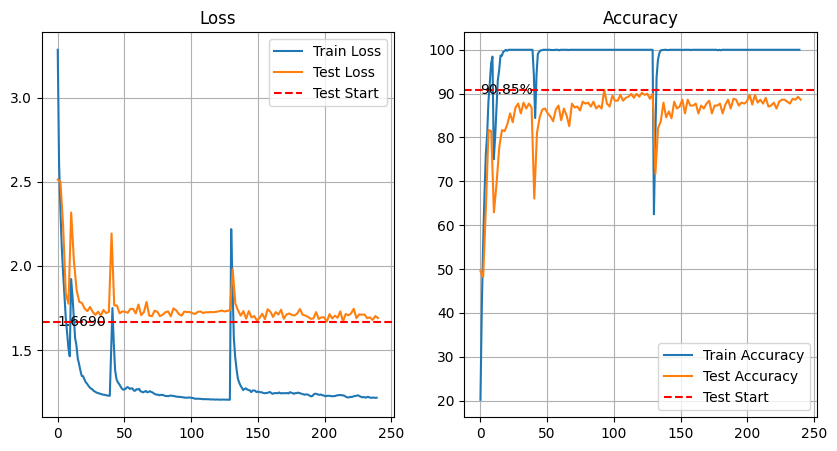

In [10]:
# plot the training and testing loss and accuracy
train_loss = [stat[0] for stat in train_stats]
train_acc = [stat[1] for stat in train_stats]
test_loss = [stat[0] for stat in test_stats]
test_acc = [stat[1] for stat in test_stats]
x_test = np.linspace(0, len(train_loss), len(test_loss))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(x_test, test_loss, label='Test Loss')
plt.axhline(np.min(test_loss), color='r', linestyle='--', label='Test Start')
plt.text(0, np.min(test_loss), f"{np.min(test_loss):.4f}", va='center', ha='left')
plt.title('Loss')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(x_test, test_acc, label='Test Accuracy')
plt.axhline(np.max(test_acc), color='r', linestyle='--', label='Test Start')
plt.text(0, np.max(test_acc), f"{np.max(test_acc):.2f}%", va='center', ha='left')
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.show()

In [11]:
# !pip install seaborn

100%|██████████| 14/14 [00:00<00:00, 48.60it/s]


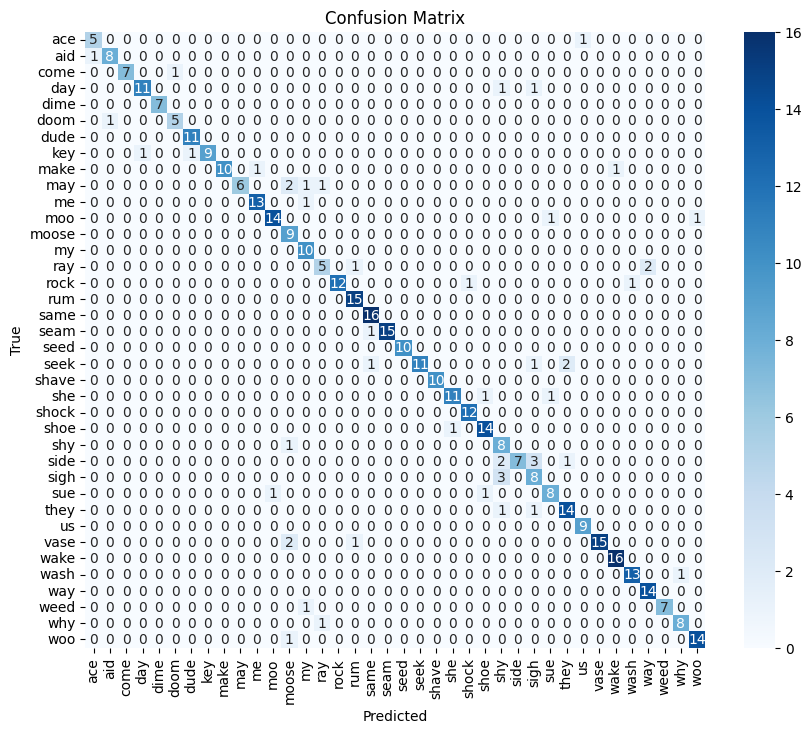

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to evaluate the model and generate the confusion matrix
def evaluate_model(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for ids, audio, adc1, adc2 in tqdm(dataloader):
            adc1 = adc1.to(device)
            adc2 = adc2.to(device)
            ids = ids.to(device)
            
            adc = torch.stack((adc1, adc2), dim=1)
            outputs = model(adc)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(ids.cpu().numpy())
    
    return all_labels, all_preds

# Evaluate the model on the validation set
labels, preds = evaluate_model(model, val_loader, device=global_device)

# Generate the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Replace IDs with dataset names
label_names = [dataset.id_to_dataset(label) for label in range(output_length)]
pred_names = [dataset.id_to_dataset(pred) for pred in range(output_length)]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pred_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()